In [ ]:
!pip install squarify

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import numpy as np
import sqlite3

In [2]:
# Initialize sqlite3 connection
conn = sqlite3.connect('ecommerce.db')
cursor = conn.cursor()

In [3]:
highest_ranked_categories = """
SELECT
    product_category_name_english AS Category,
    SUM(price) AS Sales,
    RANK() OVER (ORDER BY SUM(price) DESC) AS Ranking
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
"""
category_sales_summary = f"""
WITH RankedCategories AS (
    {highest_ranked_categories}
)
-- Top 20 categories by sales
SELECT    category,
    sales
FROM RankedCategories
WHERE Ranking <= 20
-- Other categories, aggregated
UNION ALL
SELECT
    'Other categories' AS category,
    SUM(sales) AS sales
FROM RankedCategories
WHERE Ranking > 20
"""

df1 = pd.read_sql_query(category_sales_summary, conn)

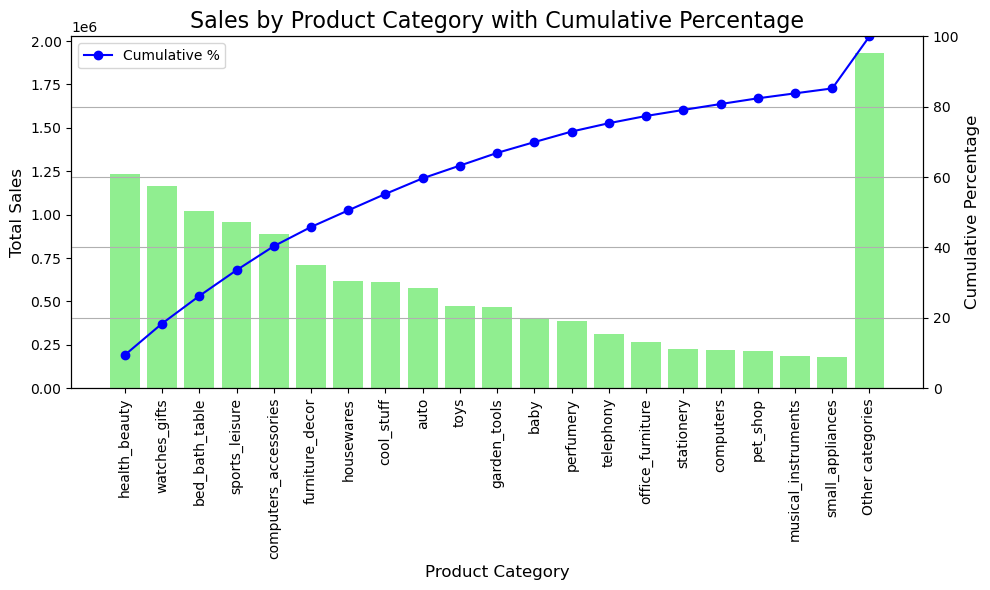

In [4]:
# Execute the query
cursor.execute(category_sales_summary)
data = cursor.fetchall()

# Split the data into two lists: one for categories and one for sales
categories = [row[0] for row in data]
sales = [row[1] for row in data]

# Calculate the percentage contribution of each category
total_sales = sum(sales)
percentages = [sale / total_sales * 100 for sale in sales]

# Calculate the cumulative percentage
cumulative_percentages = np.cumsum(percentages)

# Create a bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for sales
ax1.bar(categories, sales, color='lightgreen')

# Set labels and title for the bar chart
ax1.set_title('Sales by Product Category with Cumulative Percentage', fontsize=16)
ax1.set_xlabel('Product Category', fontsize=12)
ax1.set_ylabel('Total Sales', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Create a second y-axis for the cumulative percentage
ax2 = ax1.twinx()

# Plot the cumulative percentage as a line chart
ax2.plot(categories, cumulative_percentages, color='blue', marker='o', linestyle='-', label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage', fontsize=12)

# Add a grid and set limits for the second y-axis
ax2.grid(True)
ax2.set_ylim([0, 100])

# Show the legend
ax2.legend(loc='best')

# Adjust layout to fit the labels
plt.tight_layout()

# Show the chart
plt.show()

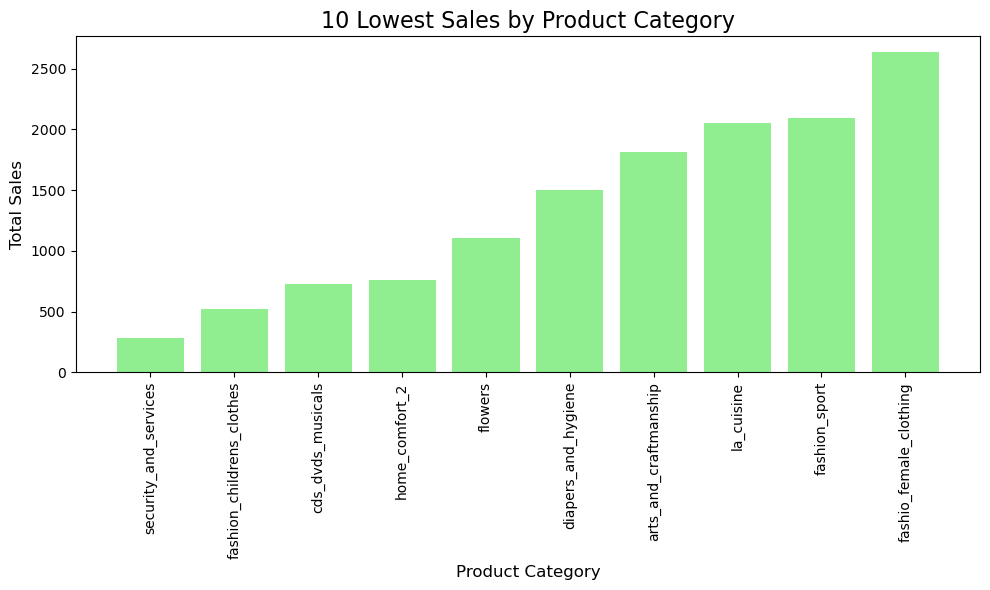

In [6]:
lowest_ranked_categories = """
SELECT * FROM (
SELECT
    product_category_name_english AS Category,
    SUM(price) AS Sales,
    RANK() OVER (ORDER BY SUM(price) ASC) AS Ranking
FROM order_items
    JOIN orders USING (order_id)
    JOIN products USING (product_id)
    JOIN product_category_name_translation USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
)
WHERE Ranking <= 10
"""
lowest_sales_category = pd.read_sql_query(lowest_ranked_categories, conn)
# Execute the query
cursor.execute(lowest_ranked_categories)
data = cursor.fetchall()

# Split the data into two lists: one for categories and one for sales
categories = [row[0] for row in data]
sales = [row[1] for row in data]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, sales, color='lightgreen')

# Add titles and labels
plt.title('10 Lowest Sales by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=90)

# Adjust layout to fit the labels
plt.tight_layout()

# Show the chart
plt.show()

In [7]:
rfm_buckets = """
-- 1. Calculate RFM scores
WITH RecencyScore AS (
    SELECT customer_unique_id,
           MAX(order_purchase_timestamp) AS last_purchase,
           NTILE(10) OVER (ORDER BY MAX(order_purchase_timestamp) DESC) AS recency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
FrequencyScore AS (
    SELECT customer_unique_id,
           COUNT(order_id) AS total_orders,
           NTILE(10) OVER (ORDER BY COUNT(order_id) ASC) AS frequency
    FROM orders
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),
MonetaryScore AS (
    SELECT customer_unique_id,
           SUM(price) AS total_spent,
           NTILE(10) OVER (ORDER BY SUM(price) ASC) AS monetary
    FROM orders
        JOIN order_items USING (order_id)
        JOIN customers USING (customer_id)
    WHERE order_status = 'delivered'
    GROUP BY customer_unique_id
),

-- 2. Combine RFM Scores and Assign Segment Labels
RFM_Segments AS (
    SELECT R.customer_unique_id,
           R.recency,
           F.frequency,
           M.monetary,
           -- Define customer segments based on RFM scores
           CASE
               WHEN R.recency <= 2 AND F.frequency >= 8 AND M.monetary >= 8 THEN 'Top Customers'
               WHEN R.recency <= 4 AND F.frequency >= 6 AND M.monetary >= 6 THEN 'High Value Customers'
               WHEN R.recency <= 6 AND F.frequency >= 4 AND M.monetary >= 4 THEN 'Medium Value Customers'
               WHEN R.recency <= 8 AND F.frequency >= 2 AND M.monetary >= 2 THEN 'Low Value Customers'
               WHEN R.recency <= 10 THEN 'At Risk Customers'
               ELSE 'Inactive Customers'
           END AS RFM_Bucket,
           R.last_purchase,
           F.total_orders,
           M.total_spent
    FROM RecencyScore R
    JOIN FrequencyScore F USING (customer_unique_id)
    JOIN MonetaryScore M USING (customer_unique_id)
)

-- 3. Calculate group statistics for plotting
SELECT RFM_Bucket, 
       AVG(JULIANDAY('now') - JULIANDAY(last_purchase)) AS avg_days_since_purchase, 
       AVG(total_spent / total_orders) AS avg_sales_per_customer,
       COUNT(*) AS customer_count
FROM RFM_Segments
GROUP BY RFM_Bucket;
"""
df3 = pd.read_sql(rfm_buckets, conn)

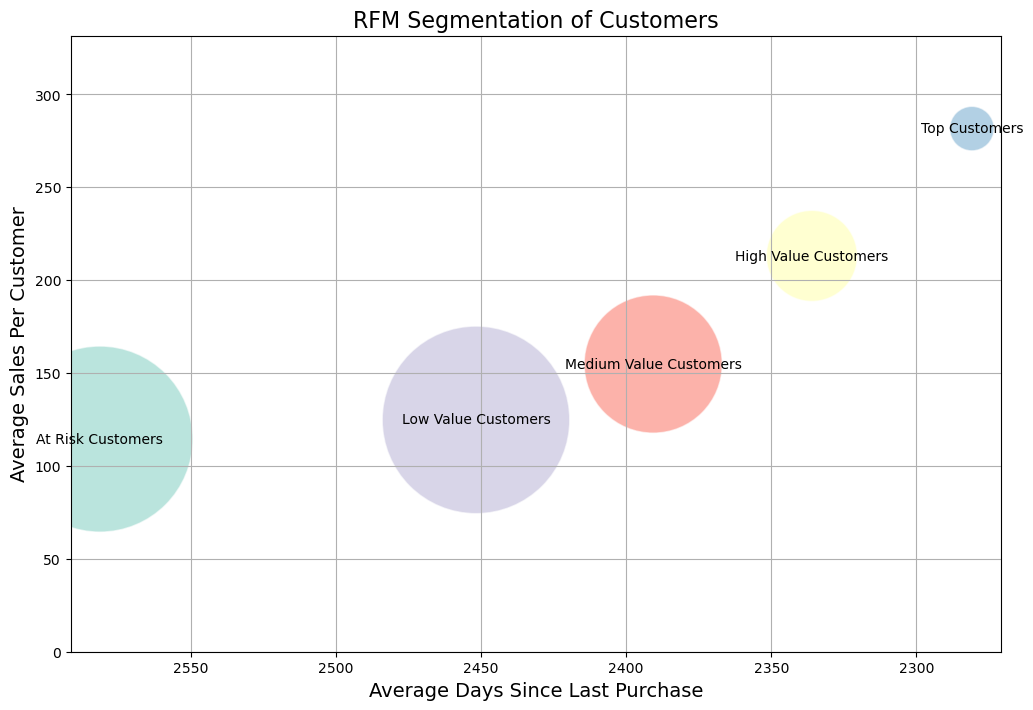

In [9]:
plt.figure(figsize=(12, 8))

# Create the scatter plot
scatter = plt.scatter(df3['avg_days_since_purchase'], df3['avg_sales_per_customer'],
                      s=df3['customer_count'] * 0.55,  # Size based on customer count
                      c=sns.color_palette('Set3', len(df3)),  # Different colors for each RFM bucket
                      alpha=0.6, edgecolors='w')  # Adding edge colors for clarity

# Set the labels and title
plt.xlabel('Average Days Since Last Purchase', fontsize=14)
plt.ylabel('Average Sales Per Customer', fontsize=14)
plt.title('RFM Segmentation of Customers', fontsize=16)
plt.grid(True)

# Annotate points with RFM bucket labels
for i in range(len(df3)):
    plt.annotate(df3['RFM_Bucket'][i], 
                 (df3['avg_days_since_purchase'][i], df3['avg_sales_per_customer'][i]), 
                 ha='center', va='center', fontsize=10)

# Optional: Invert x-axis if needed and set limits
plt.gca().invert_xaxis()  # Uncomment this if you want to invert the x-axis
plt.xlim(df3['avg_days_since_purchase'].max() + 10, df3['avg_days_since_purchase'].min() - 10)
plt.ylim(0, df3['avg_sales_per_customer'].max() + 50)  # Adjust as needed

# Show the plot
plt.show()

In [4]:
#to see the results of table orders join with order_items table join with products and join with product_category
# Top 20 sales of products

df_order_prod_name_values_top20 = pd.read_sql("""
    SELECT prod_eng.product_category_name_english, SUM(ord_i.price * ord_i.order_item_id) AS sales, SUM(ord_i.order_item_id) AS sum_order_qty, ord_i.price
    FROM orders ord
    INNER JOIN order_items ord_i ON ord.order_id = ord_i.order_id
    INNER JOIN products prod ON ord_i.product_id = prod.product_id
    INNER JOIN product_category_name_translation prod_eng ON prod.product_category_name = prod_eng.product_category_name
    WHERE ord.order_status = 'delivered'
    GROUP BY prod_eng.product_category_name_english
    ORDER BY sales DESC
    LIMIT 20;
""", conn)

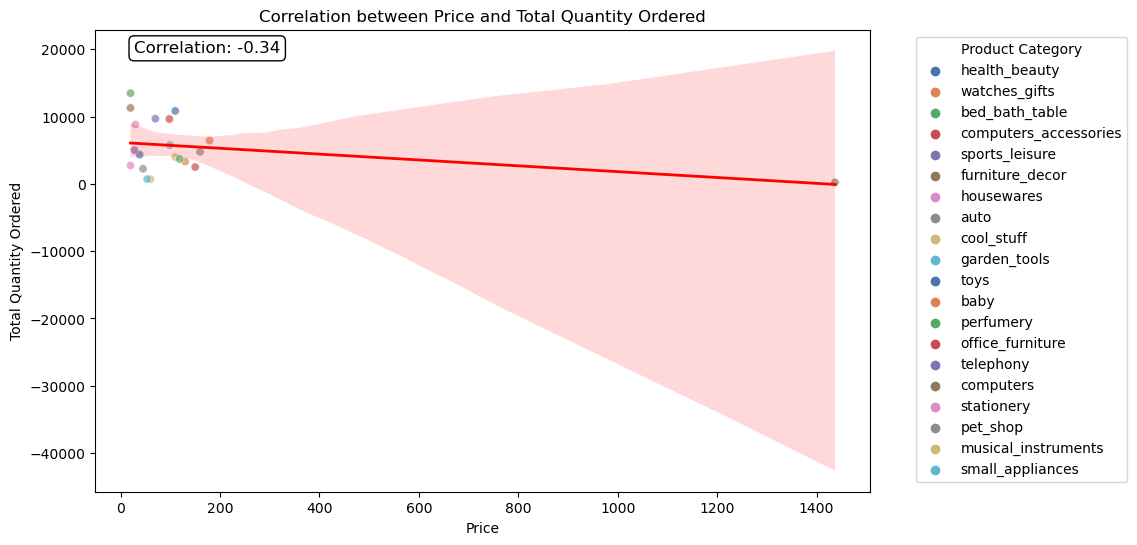

In [11]:
#correlation between sum_order_qty and price
# These result in the same plot! 
# Calculate the correlation between price and sum_order_qty
correlation = df_order_prod_name_values_top20['price'].corr(df_order_prod_name_values_top20['sum_order_qty'])

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price',
                y='sum_order_qty',
                data=df_order_prod_name_values_top20,
                hue='product_category_name_english', 
                palette='deep',  
                alpha=0.7)

# Add a regression line
sns.regplot(x='price',
            y='sum_order_qty',
            data=df_order_prod_name_values_top20,
            scatter=False,
            line_kws={'color': 'red', 'lw': 2})

# Annotate the correlation value
plt.annotate(f'Correlation: {correlation:.2f}', 
             xy=(0.05, 0.95), 
             xycoords='axes fraction', 
             fontsize=12, 
             ha='left', 
             bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Set titles and labels
plt.title('Correlation between Price and Total Quantity Ordered')
plt.xlabel('Price')
plt.ylabel('Total Quantity Ordered')

plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [12]:
# what are the top order quantity for the product category 

df_order_prod_name_values_top20 = pd.read_sql("""
    SELECT prod_eng.product_category_name_english, SUM(ord_i.price * ord_i.order_item_id) AS sales, SUM(ord_i.order_item_id) AS sum_order_qty, ord_i.price
    FROM orders ord
    INNER JOIN order_items ord_i ON ord.order_id = ord_i.order_id
    INNER JOIN products prod ON ord_i.product_id = prod.product_id
    INNER JOIN product_category_name_translation prod_eng ON prod.product_category_name = prod_eng.product_category_name
    WHERE ord.order_status = 'delivered'
    GROUP BY prod_eng.product_category_name_english
    ORDER BY sum_order_qty DESC
    LIMIT 20;
""", conn)

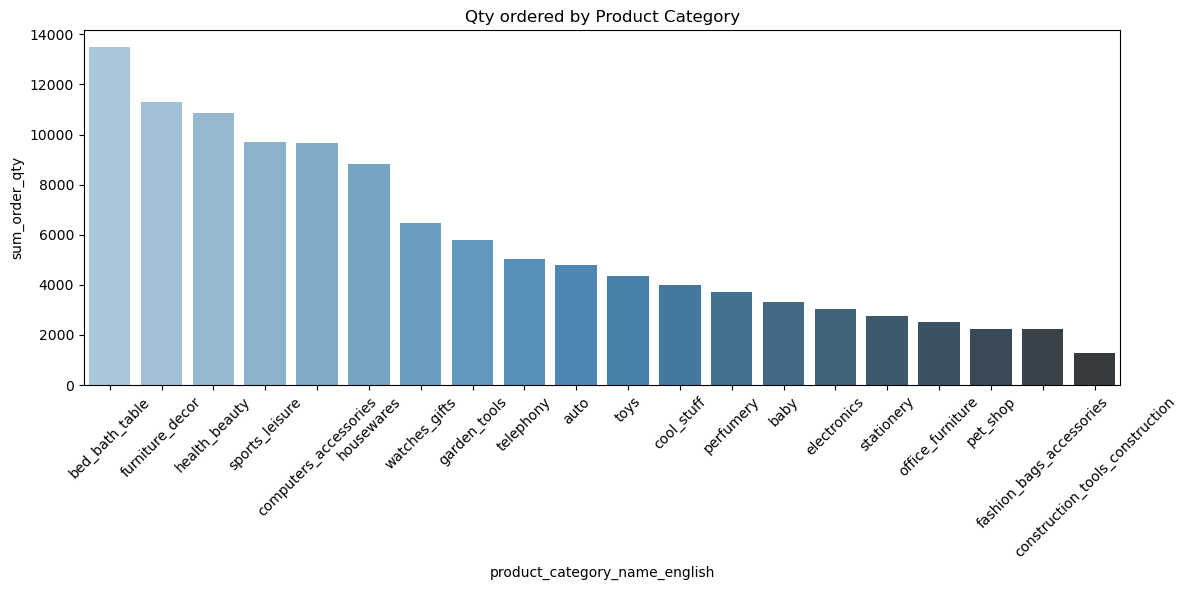

In [13]:
# Using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='product_category_name_english', y='sum_order_qty', data=df_order_prod_name_values_top20, palette='Blues_d')
plt.title('Qty ordered by Product Category')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

In [14]:
#breakdown join the tables 

#to see the results of table orders join with order_items table
df_quantity_ordered = pd.read_sql("""
    SELECT *
    FROM orders ord
    INNER JOIN order_items ord_i ON ord.order_id = ord_i.order_id
    INNER JOIN products prod ON ord_i.product_id = prod.product_id
    INNER JOIN product_category_name_translation prod_eng ON prod.product_category_name = prod_eng.product_category_name
    WHERE order_status = "delivered" AND order_purchase_timestamp >= '2017-01-01'; 
""", conn)
# Define the top 5 categories
top_categories = [
    'bed_bath_table',
    'furniture_decor',
    'health_beauty',
    'sports_leisure',
    'computers_accessories'
]
# Filter the DataFrame to include only the top 5 categories
filtered_df = df_quantity_ordered[df_quantity_ordered['product_category_name_english'].isin(top_categories)]
# Convert order_estimated_delivery_date to datetime format
filtered_df['order_estimated_delivery_date'] = pd.to_datetime(filtered_df['order_estimated_delivery_date'])

# Change the format to "%Y-%m"
filtered_df['order_estimated_delivery_date'] = filtered_df['order_estimated_delivery_date'].dt.strftime('%Y-%m')
# Assuming df_quantity_ordered already has the order_estimated_delivery_date in '%Y-%m' format

# Count the number of orders per month for each top category
monthly_counts = (filtered_df.groupby(['order_estimated_delivery_date', 'product_category_name_english'])
                  .size()
                  .reset_index(name='order_count'))

# Convert order_estimated_delivery_date to datetime
monthly_counts['order_estimated_delivery_date'] = pd.to_datetime(monthly_counts['order_estimated_delivery_date'])
# Pivot the data for easier plotting
pivot_df = monthly_counts.pivot(index='order_estimated_delivery_date', 
                                 columns='product_category_name_english', 
                                 values='order_count').fillna(0)

C:\Users\Danrui Zhang\AppData\Local\Temp\ipykernel_30116\3919647739.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['order_estimated_delivery_date'] = pd.to_datetime(filtered_df['order_estimated_delivery_date'])
C:\Users\Danrui Zhang\AppData\Local\Temp\ipykernel_30116\3919647739.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['order_estimated_delivery_date'] = filtered_df['order_estimated_delivery_date'].dt.strftime('%Y-%m')


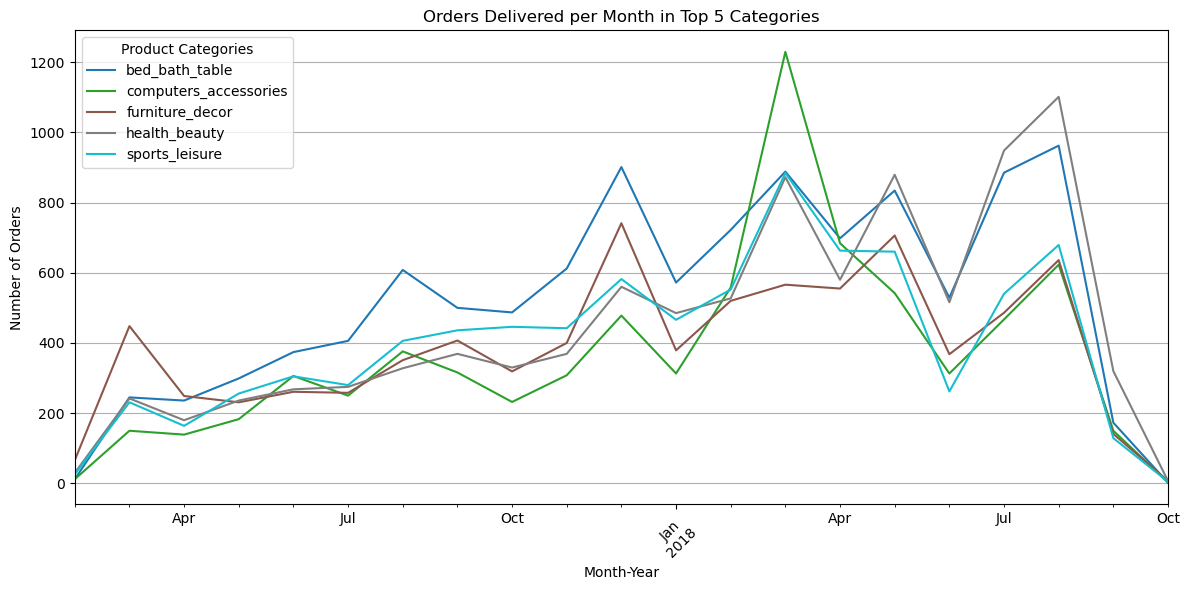

In [15]:
# Plotting the data
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='line', stacked=False, colormap='tab10', ax=plt.gca())
plt.title('Orders Delivered per Month in Top 5 Categories')
plt.xlabel('Month-Year')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.legend(title='Product Categories')
plt.tight_layout()  # Adjust layout to fit labels
plt.show()

In [3]:
#to see the average unit price group by product category name
df_average_unit_price_by_product_cat = pd.read_sql("""
    SELECT
    product_category_name_english AS Category,
    SUM(price * order_item_id) AS Total_Sales,
    SUM(order_item_id) AS Total_Quantity,
    SUM(price * order_item_id) / NULLIF(SUM(order_item_id), 0) AS Average_Unit_Price
FROM order_items
JOIN orders USING (order_id)
JOIN products USING (product_id)
JOIN product_category USING (product_category_name)
WHERE order_status = 'delivered'
GROUP BY product_category_name_english
ORDER BY Average_Unit_Price DESC;
""", conn)
df_sorted = df_average_unit_price_by_product_cat.sort_values(by='Total_Sales', ascending=False)
df_sorted_q = df_average_unit_price_by_product_cat.sort_values(by='Total_Quantity', ascending=False)

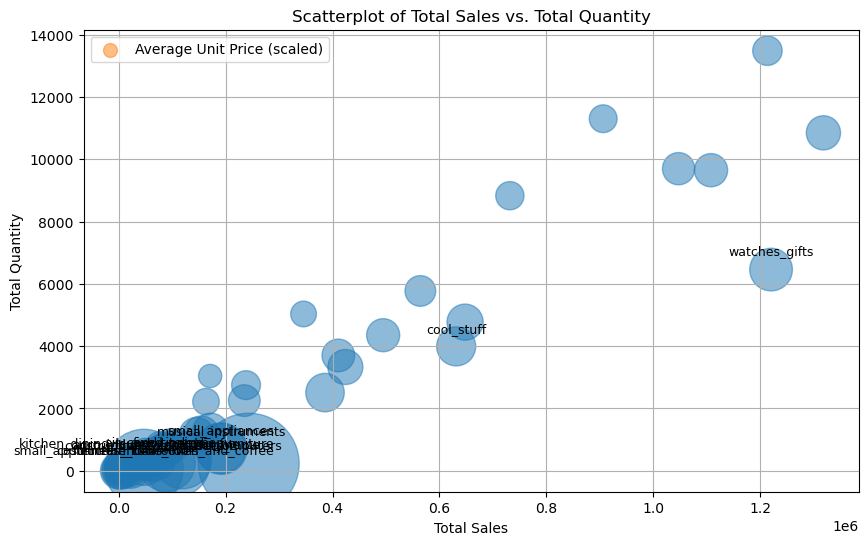

In [9]:
# Define a threshold for higher average unit prices
threshold = df_average_unit_price_by_product_cat['Average_Unit_Price'].quantile(0.8)  # For example, top 20%

# Create the scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    df_average_unit_price_by_product_cat['Total_Sales'], 
    df_average_unit_price_by_product_cat['Total_Quantity'], 
    s=df_average_unit_price_by_product_cat['Average_Unit_Price'] * 5,  # Scale bubble sizes for better visibility
    alpha=0.5
)

# Add labels and title
plt.title('Scatterplot of Total Sales vs. Total Quantity')
plt.xlabel('Total Sales')
plt.ylabel('Total Quantity')

# Annotate points with higher average unit prices
high_value_points = df_average_unit_price_by_product_cat[df_average_unit_price_by_product_cat['Average_Unit_Price'] > threshold]
for index, row in high_value_points.iterrows():
    plt.annotate(row['Category'], 
                 (row['Total_Sales'], row['Total_Quantity']),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=9)

# Add a legend for the bubble sizes
bubble_size_legend = plt.scatter([], [], s=100, alpha=0.5, label='Average Unit Price (scaled)')
plt.legend(loc='upper left')

# Show the plot
plt.grid()
plt.show()


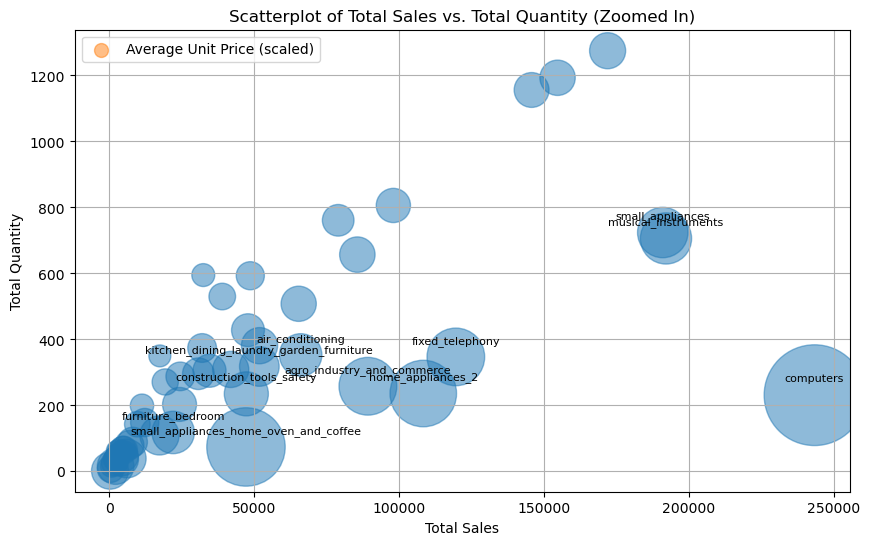

In [5]:
# Filter the DataFrame for the specific conditions
filtered_df = df_average_unit_price_by_product_cat[(df_average_unit_price_by_product_cat['Total_Quantity'] < 2000) & (df_average_unit_price_by_product_cat['Total_Sales'] < 400000)]

# Create the scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    filtered_df['Total_Sales'], 
    filtered_df['Total_Quantity'], 
    s=filtered_df['Average_Unit_Price'] * 5,  # Scale bubble sizes for better visibility
    alpha=0.5
)

# Add labels and title
plt.title('Scatterplot of Total Sales vs. Total Quantity (Zoomed In)')
plt.xlabel('Total Sales')
plt.ylabel('Total Quantity')

# Optionally annotate points with higher average unit prices
threshold = filtered_df['Average_Unit_Price'].quantile(0.8)  # Adjust if needed
high_value_points = filtered_df[filtered_df['Average_Unit_Price'] > threshold]
for index, row in high_value_points.iterrows():
    plt.annotate(row['Category'], 
                 (row['Total_Sales'], row['Total_Quantity']),
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center', 
                 fontsize=8)

# Add a legend for the bubble sizes
bubble_size_legend = plt.scatter([], [], s=100, alpha=0.5, label='Average Unit Price (scaled)')
plt.legend(loc='upper left')    
    
# Show the plot
plt.grid()
plt.show()

In [11]:
# Step 1: Create a new table 'top_10_cities' to store data for the top 10 cities
create_top_10_cities_table = '''
CREATE TABLE IF NOT EXISTS top_10_cities (
    customer_city TEXT PRIMARY KEY,
    num_orders INTEGER,
    total_revenue REAL
);
'''
cursor.execute(create_top_10_cities_table)
conn.commit()

# Step 2: Insert data into the 'top_10_cities' table based on the top 10 cities by number of orders
insert_top_10_by_orders = '''
INSERT OR REPLACE INTO top_10_cities (customer_city, num_orders, total_revenue)
SELECT customer_city, 
       COUNT(o.order_id) AS num_orders, 
       SUM(oi.price) AS total_revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY customer_city
ORDER BY num_orders DESC
LIMIT 10;
'''
cursor.execute(insert_top_10_by_orders)
conn.commit()

# Step 3: Fetch the data from the new 'top_10_cities' table and load it into a pandas DataFrame
top_10_cities_df = pd.read_sql_query("SELECT * FROM top_10_cities;", conn)

# Step 4: Sort the DataFrame by total_revenue in descending order
top_10_cities_sorted = top_10_cities_df.sort_values(by='total_revenue', ascending=False)


C:\Users\Danrui Zhang\AppData\Local\Temp\ipykernel_4840\1367542273.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(top_10_cities_df['customer_city'], rotation=45, ha='right', fontsize=10)


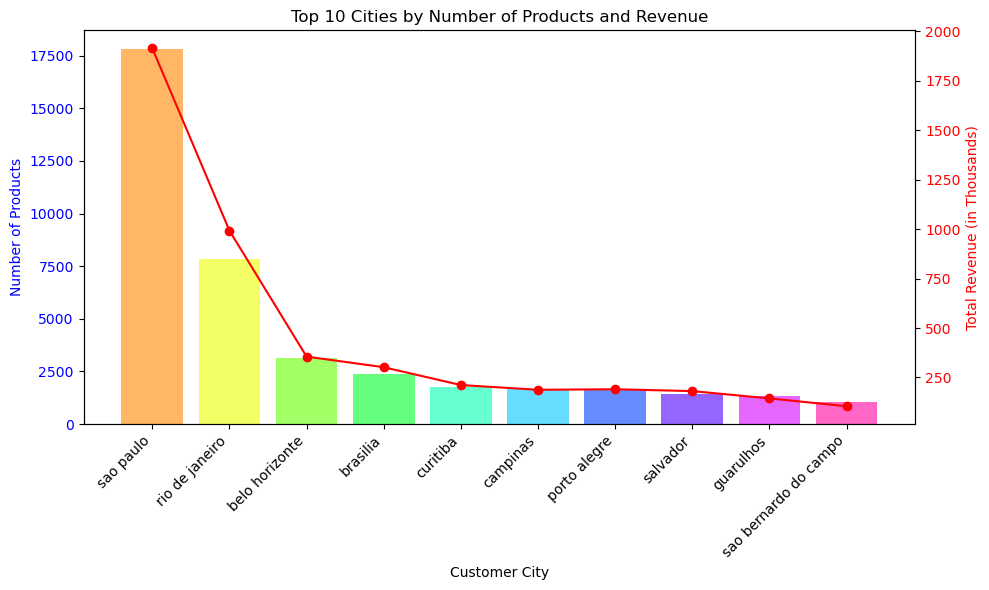

In [12]:
# Query to get the top 10 cities by number of products and total revenue
top_10_cities_query = '''
SELECT c.customer_city, 
       SUM(oi.price) AS total_revenue,
       COUNT(oi.product_id) AS num_products
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
GROUP BY c.customer_city
ORDER BY num_products DESC
LIMIT 10;
'''

# Execute the query and load the results into a pandas DataFrame
top_10_cities_df = pd.read_sql_query(top_10_cities_query, conn)

# Scale the total revenue to thousands
top_10_cities_df['total_revenue'] = top_10_cities_df['total_revenue'] / 1000

# Create a list of unique colors for each city
colors = sns.color_palette("hsv", len(top_10_cities_df))

# Creating a bar plot to display both number of products and total revenue in the same graph
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for number of products (left y-axis) using different colors for each city
ax1.set_xlabel('Customer City')
ax1.set_ylabel('Number of Products', color='blue')
ax1.bar(top_10_cities_df['customer_city'], top_10_cities_df['num_products'], color=colors, alpha=0.6, label='Number of Products')
ax1.tick_params(axis='y', labelcolor='blue')

# Rotate the x-axis city labels for clarity and increase font size
ax1.set_xticklabels(top_10_cities_df['customer_city'], rotation=45, ha='right', fontsize=10)

# Creating a secondary y-axis to display revenue in thousands (right y-axis)
ax2 = ax1.twinx()  
ax2.set_ylabel('Total Revenue (in Thousands)', color='red')  
ax2.plot(top_10_cities_df['customer_city'], top_10_cities_df['total_revenue'], color='red', marker='o', label='Total Revenue')
ax2.tick_params(axis='y', labelcolor='red')

# Adding titles and labels
plt.title('Top 10 Cities by Number of Products and Revenue')
fig.tight_layout()  # To adjust the layout

# Show the plot
plt.show()

C:\Users\Danrui Zhang\AppData\Local\Temp\ipykernel_30116\1416104563.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_result, x='avg_delivery_time', y='customer_city', palette='viridis', ci=None)


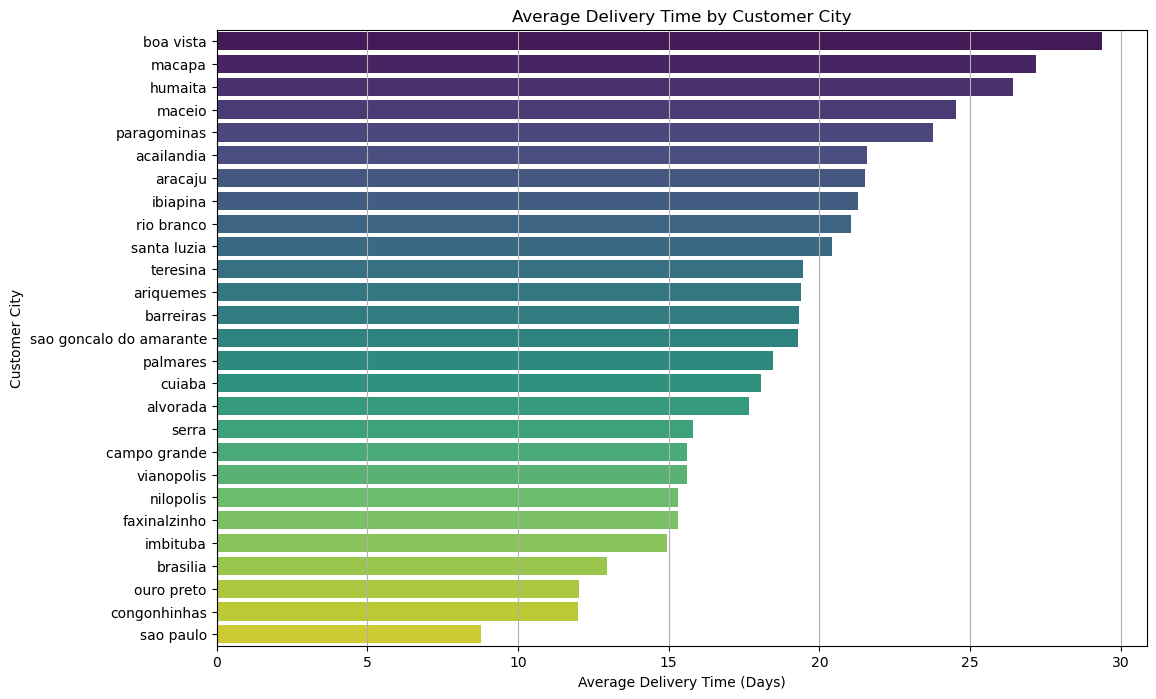

In [17]:
df_result = pd.read_sql('''SELECT 
    c.customer_city,                        -- or c.customer_city for city-level analysis
    AVG(julianday(o.order_delivered_customer_date) - julianday(o.order_purchase_timestamp)) AS avg_delivery_time,
    COUNT(o.order_id) AS total_orders
FROM 
    orders o
JOIN 
    customers c ON o.customer_id = c.customer_id
WHERE 
    o.order_status = 'delivered'             -- Filter to include only delivered orders
GROUP BY 
    c.customer_state                          -- Change to c.customer_city if analyzing by city
ORDER BY 
    avg_delivery_time DESC;                  -- Order by average delivery time, descending


'''
, conn)
plt.figure(figsize=(12, 8))
sns.barplot(data=df_result, x='avg_delivery_time', y='customer_city', palette='viridis', ci=None)
plt.title('Average Delivery Time by Customer City')
plt.xlabel('Average Delivery Time (Days)')
plt.ylabel('Customer City')
plt.grid(axis='x')
plt.show()

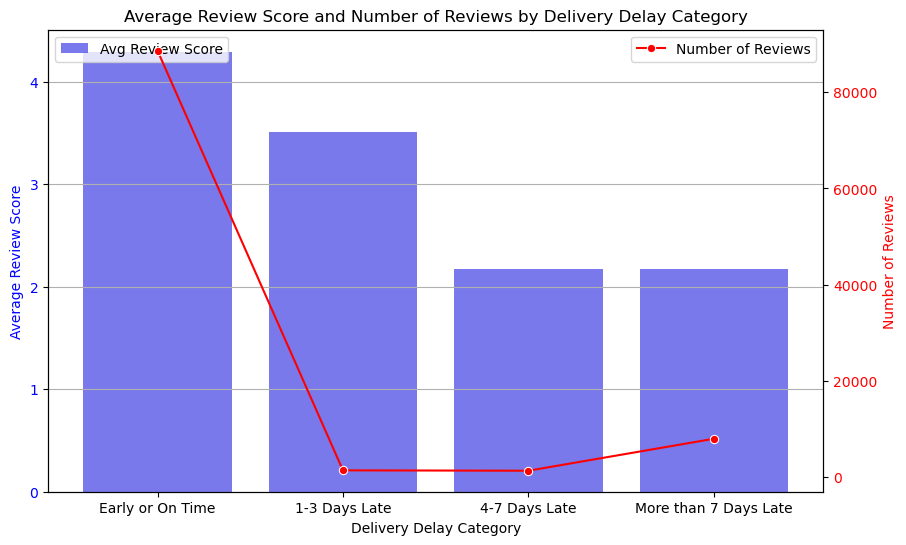

In [18]:
df = pd.read_sql('''SELECT 
   delay_category,
   AVG(review_score) AS avg_review_score,
   COUNT(*) AS num_reviews
FROM (
    SELECT 
        CASE 
          WHEN delivery_delay <= 0 THEN 'Early or On Time'
          WHEN delivery_delay BETWEEN 1 AND 3 THEN '1-3 Days Late'
          WHEN delivery_delay BETWEEN 4 AND 7 THEN '4-7 Days Late'
          ELSE 'More than 7 Days Late'
        END AS delay_category,
        review_score
    FROM (
        SELECT 
            order_id,
            (julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) AS delivery_delay
        FROM orders
        WHERE order_delivered_customer_date IS NOT NULL 
          AND order_estimated_delivery_date IS NOT NULL
    ) AS o
    JOIN order_reviews AS r
    ON o.order_id = r.order_id
) AS delays
GROUP BY delay_category;'''
, conn)
# Ensure the 'delay_category' is treated as a categorical variable with the specified order
df['delay_category'] = pd.Categorical(df['delay_category'], 
                                      categories=['Early or On Time', '1-3 Days Late', '4-7 Days Late', 'More than 7 Days Late'], 
                                      ordered=True)

# Combined bar plot for average review score and number of reviews
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar for average review score
sns.barplot(data=df, x='delay_category', y='avg_review_score', ax=ax1, color='b', label='Avg Review Score', alpha=0.6)
ax1.set_ylabel('Average Review Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis
ax2 = ax1.twinx()

# Line for number of reviews
# Use categorical variable directly
sns.lineplot(data=df.sort_values('delay_category'), x='delay_category', y='num_reviews', ax=ax2, color='r', marker='o', label='Number of Reviews', sort=False)
ax2.set_ylabel('Number of Reviews', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add titles and legends
plt.title('Average Review Score and Number of Reviews by Delivery Delay Category')
ax1.set_xlabel('Delivery Delay Category')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add grid for better readability
ax1.grid(axis='y')

plt.show()

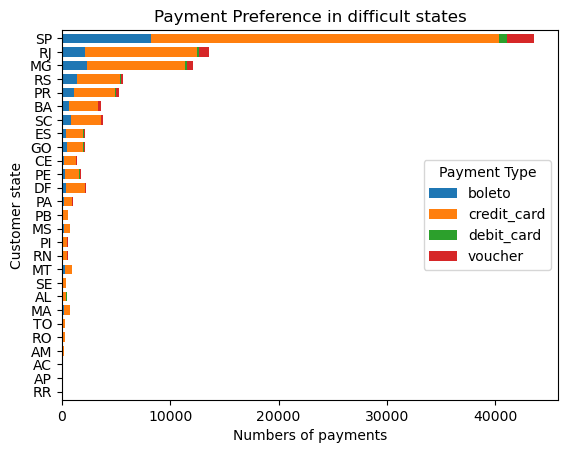

In [19]:
state_payment_preference = """
SELECT
    c.customer_state as state,
    p.payment_type,
    COUNT(*) AS numbers_of_payment
FROM orders o
INNER JOIN customers c ON c.customer_id = o.customer_id
INNER JOIN order_payments p ON o.order_id = p.order_id
WHERE p.payment_type <> 'not_defined'
GROUP BY
    c.customer_state, p.payment_type
ORDER BY
    c.customer_state, p.payment_type
"""
df = pd.read_sql(state_payment_preference,conn)
pivot_st_pre = df.pivot_table(
    index='state', 
    columns='payment_type', 
    values='numbers_of_payment', 
    aggfunc='sum',
    fill_value = 0
)
pivot_st_pre = pivot_st_pre.sort_values(by=pivot_st_pre.columns.tolist()[2:], ascending=True)
pivot_st_pre = pivot_st_pre.reset_index()
pivot_st_pre.plot(x='state', kind='barh', stacked=True, width=0.7,
        title='Payment Preference in difficult states')
plt.ylabel('Customer state')
plt.xlabel('Numbers of payments')
plt.legend(title='Payment Type', loc='right')
plt.show()

In [21]:
payment_value = """
SELECT
    p.payment_type,
    AVG(p.payment_value) AS average_value,
    Count(p.payment_type) AS numbers_of_payment
FROM order_payments p 
Where p.payment_type <> 'not_defined'
GROUP BY
    p.payment_type
"""
df = pd.read_sql(payment_value ,conn)
df = df.sort_values(by='average_value', ascending=True)
df

,payment_type,average_value,numbers_of_payment
3,voucher,65.703354,5775
2,debit_card,142.570170,1529
0,boleto,145.034435,19784
1,credit_card,163.319021,76795


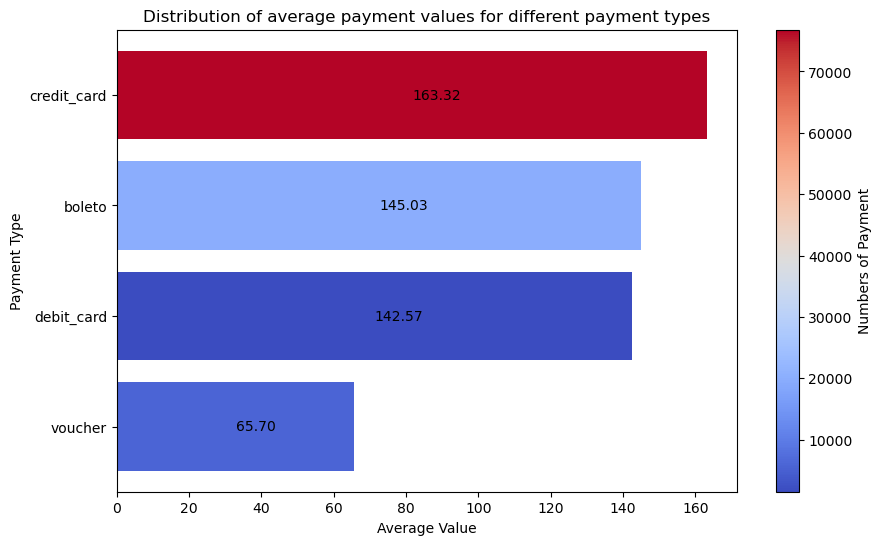

In [22]:
import matplotlib as mpl

# Set the color map and adjust the color shade according to the number of payments
norm = mpl.colors.Normalize(vmin=df['numbers_of_payment'].min(), vmax=df['numbers_of_payment'].max())
cmap = sns.color_palette("coolwarm", as_cmap=True)

#  Generate a color for each bar
colors = cmap(norm(df['numbers_of_payment']))

# Draw a horizontal bar chart and set the colors
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df['payment_type'], df['average_value'], color=colors)
ax.set_xlabel('Average Value')
ax.set_ylabel('Payment Type')
ax.set_title('Distribution of average payment values for different payment types')

# text average value
for bar in bars:
    width = bar.get_width() 
    ax.text(width/2, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
            va='center', ha='left', color='black', fontsize=10)

# Create a ScalarMappable object to display the color bars
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add color gradient legend, explicitly pass axis ax
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Numbers of Payment')

plt.show()